# Amazon Fine Food Reviews Analysis
 Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

####  Number of reviews: 568,454
#### Number of users: 256,059
#### Number of products: 74,258
#### Timespan: Oct 1999 - Oct 2012
#### Number of Attributes/Columns in data: 10

### Attribute Information:

 1.Id
2 ProductId - unique identifier for the product
3 UserId - unqiue identifier for the user
4 ProfileName
5 HelpfulnessNumerator - number of users who found the review helpful
6 HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7 Score - rating between 1 and 5
8 Time - timestamp for the review
9 Summary - brief summary of the review
10 Text - text of the review
## Objective:
##### Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


##### [Q] How to determine if a review is positive or negative?

##### [Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Data is stored in csv file.
data = pd.read_csv('C:/Users/taxak/Downloads/Reviews.csv')
print(data.tail(5))
print(data.shape)

filter_data = pd.DataFrame(data)

df = filter_data[filter_data.Score != 3]

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = df['Score']
positiveNegative = actualScore.map(partition) 
df['Score'] = positiveNegative

print(df.head(5))

            Id   ProductId          UserId              ProfileName  \
568449  568450  B001EO7N10  A28KG5XORO54AY         Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z            pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH  Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                 srfell17   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
568449                     0                       0      5  1299628800   
568450                     0                       0      2  1331251200   
568451                     2                       2      5  1329782400   
568452                     1                       1      5  1331596800   
568453                     0                       0      5  1338422400   

                                   Summary  \
568449                 Will not do without   
568450                        

C:\Users\taxak\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
sorted_data = df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [3]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [4]:
final_dat = final.head(70000)
final_da = final.head(12300)
print(final_dat.shape)

(70000, 10)


In [5]:
final_d = final_dat[final_dat['Score']=='negative']
final_dt = final_da[final_da['Score']=='positive']

In [6]:
print(final_d.shape)
print(final_dt.shape)


(10368, 10)
(10434, 10)


In [7]:
frames = [final_d,final_dt]
result = pd.concat(frames)
print(result.shape)

(20802, 10)


In [8]:
sorted_d = result.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print(sorted_d.head(5))

            Id   ProductId          UserId               ProfileName  \
150523  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
150500  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
451855  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
374358  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
451854  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
150523                     0                       0  positive  939340800   
150500                     2                       2  positive  940809600   
451855                     0                       0  positive  944092800   
374358                     1                       2  positive  944438400   
451854                     0                       0  positive  946857600   

                                                  Summary  \
150523                          EVERY book 

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.


7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviewse finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords

7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)



In [9]:
import nltk
import string

import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re


from nltk.corpus import stopwords
nltk.download('stopwords') #downloading stopwords

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'wh

# Bag of words(BOW)

In [10]:
#Bag of words 
# Here we are finding a vector v(i) for corresponding row r(i) in our dataset .

count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sorted_d['Text'].values)
# CountVectorizer() is a function used to
# Convert a collection of text documents to a matrix of token counts
#This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.
# If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection 
# then the number of features will be equal to the vocabulary size found by analyzing the data

In [11]:

final_counts.get_shape()
# This return us a sparse matrix having 115281 features

(20802, 31648)

In [12]:
type(final_counts)
# here we get a sparse matrix
# scipy is a scientific python
# If tese row vectors are sparse vectors  then matrix is sparse matrix
# In row vectors most of these values of any vector of any row are zero
# So we require a huge space to store this matrix


scipy.sparse.csr.csr_matrix

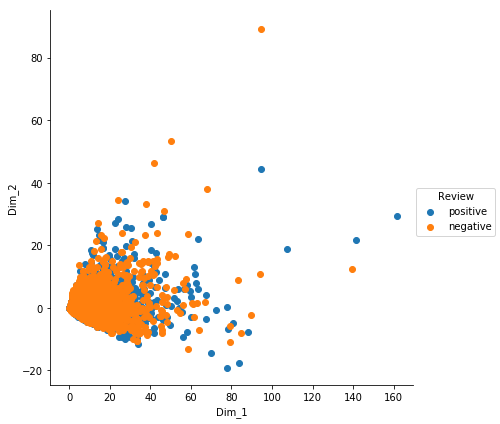

In [13]:
from sklearn.manifold import TSNE
import seaborn as sn

from sklearn.decomposition import TruncatedSVD

Score = sorted_d['Score']

dim_reduction_model =TruncatedSVD(n_components=2,random_state=0)
reduced_vectors = dim_reduction_model.fit_transform(final_counts)



#model = TSNE(n_components=2, random_state=0)
#tsne_data = model.fit_transform(final_counts) 


# attaching the label for each 2-d data point 
tsne_data = np.vstack((reduced_vectors.T, Score)).T
# creating a new data fram which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

# KNN classifier

In [14]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter

sorted_d['Score'].value_counts()

C:\Users\taxak\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


positive    10434
negative    10368
Name: Score, dtype: int64

In [15]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts, Score, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(21)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 21 is %d%%' % (acc))


CV accuracy for k = 1 is 62%

CV accuracy for k = 3 is 63%

CV accuracy for k = 5 is 65%

CV accuracy for k = 7 is 65%

CV accuracy for k = 9 is 65%

CV accuracy for k = 11 is 66%

CV accuracy for k = 13 is 67%

CV accuracy for k = 15 is 67%

CV accuracy for k = 17 is 67%

CV accuracy for k = 19 is 67%

CV accuracy for k = 21 is 67%

CV accuracy for k = 23 is 67%

CV accuracy for k = 25 is 66%

CV accuracy for k = 27 is 66%

CV accuracy for k = 29 is 66%

****Test accuracy for k = 21 is 67%



The optimal number of neighbors is 17.


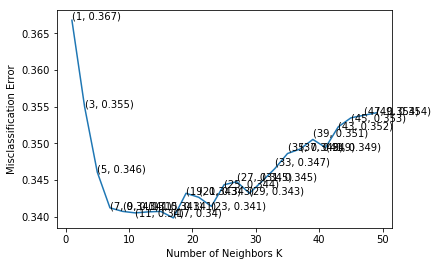

('the misclassification error for each k value is : ', array([0.367, 0.355, 0.346, 0.341, 0.341, 0.34 , 0.341, 0.341, 0.34 ,
       0.343, 0.343, 0.341, 0.344, 0.345, 0.343, 0.345, 0.347, 0.349,
       0.349, 0.351, 0.349, 0.352, 0.353, 0.354, 0.354]))


In [16]:

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    sco = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(sco.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [17]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 67.136677%


In [18]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(23)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 23 is %d%%' % (acc))

C:\Users\taxak\Anaconda2\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



CV accuracy for k = 1 is 62%

CV accuracy for k = 3 is 63%

CV accuracy for k = 5 is 65%

CV accuracy for k = 7 is 65%

CV accuracy for k = 9 is 65%

CV accuracy for k = 11 is 66%

CV accuracy for k = 13 is 67%

CV accuracy for k = 15 is 67%

CV accuracy for k = 17 is 67%

CV accuracy for k = 19 is 67%

CV accuracy for k = 21 is 67%

CV accuracy for k = 23 is 67%

CV accuracy for k = 25 is 66%

CV accuracy for k = 27 is 66%

CV accuracy for k = 29 is 66%

****Test accuracy for k = 23 is 66%



The optimal number of neighbors is 17.


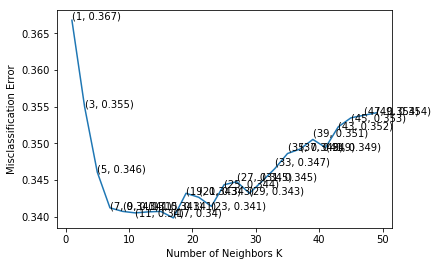

('the misclassification error for each k value is : ', array([0.367, 0.355, 0.346, 0.341, 0.341, 0.34 , 0.341, 0.341, 0.34 ,
       0.343, 0.343, 0.341, 0.344, 0.345, 0.343, 0.345, 0.347, 0.349,
       0.349, 0.351, 0.349, 0.352, 0.353, 0.354, 0.354]))


In [19]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    sco = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(sco.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)
for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [20]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 67.136677%


# Naive Bayes(BOW)

In [21]:
from sklearn.naive_bayes import BernoulliNB

In [22]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts, Score, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,50,2):
    # instantiate learning model (k = 30)
    nb = BernoulliNB(alpha=i, binarize=0.0, class_prior=None, fit_prior=True)

    # fitting the model on crossvalidation train
    nb.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = nb.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for alpha = %d is %d%%' % (i, acc))
    
nb = BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)
nb.fit(X_tr,y_tr)
pred = nb.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha=1 is %d%%' % (acc))


CV accuracy for alpha = 1 is 86%

CV accuracy for alpha = 3 is 86%

CV accuracy for alpha = 5 is 86%

CV accuracy for alpha = 7 is 86%

CV accuracy for alpha = 9 is 86%

CV accuracy for alpha = 11 is 85%

CV accuracy for alpha = 13 is 85%

CV accuracy for alpha = 15 is 85%

CV accuracy for alpha = 17 is 85%

CV accuracy for alpha = 19 is 85%

CV accuracy for alpha = 21 is 84%

CV accuracy for alpha = 23 is 84%

CV accuracy for alpha = 25 is 84%

CV accuracy for alpha = 27 is 84%

CV accuracy for alpha = 29 is 84%

CV accuracy for alpha = 31 is 83%

CV accuracy for alpha = 33 is 83%

CV accuracy for alpha = 35 is 83%

CV accuracy for alpha = 37 is 83%

CV accuracy for alpha = 39 is 83%

CV accuracy for alpha = 41 is 83%

CV accuracy for alpha = 43 is 82%

CV accuracy for alpha = 45 is 82%

CV accuracy for alpha = 47 is 82%

CV accuracy for alpha = 49 is 82%

****Test accuracy for alpha=1 is 87%



The optimal value of alpha is 1.


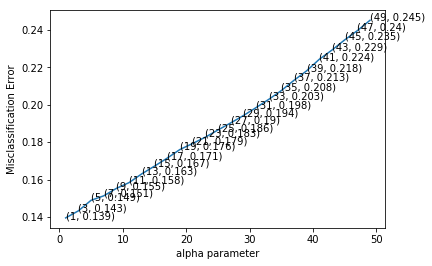

('the misclassification error for each alpha value is : ', array([0.139, 0.143, 0.149, 0.151, 0.155, 0.158, 0.163, 0.167, 0.171,
       0.176, 0.179, 0.183, 0.186, 0.19 , 0.194, 0.198, 0.203, 0.208,
       0.213, 0.218, 0.224, 0.229, 0.235, 0.24 , 0.245]))


In [23]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    nb = BernoulliNB(alpha=k, binarize=0.0, class_prior=None, fit_prior=True)
    sco = cross_val_score(nb, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(sco.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('alpha parameter')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [24]:
# instantiate learning model alpha = optimal_alpha
nb_optimal = BernoulliNB(alpha=optimal_alpha, binarize=0.0, class_prior=None, fit_prior=True)

# fitting the model
nb_optimal.fit(X_1, y_1)

# predict the response
pred = nb_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes for alpha = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the naive bayes for alpha = 1 is 86.732895%


# precision , recall , f1-score 

In [25]:
from sklearn.metrics import classification_report

target_names = ['class positive', 'class negative']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

class positive       0.89      0.84      0.86      3121
class negative       0.85      0.89      0.87      3120

   avg / total       0.87      0.87      0.87      6241



# Confusion - Matrix(BOw)

Confusion matrix, without normalization
[[2625  496]
 [ 332 2788]]
Normalized confusion matrix
[[0.84 0.16]
 [0.11 0.89]]


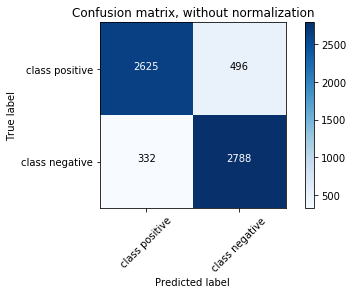

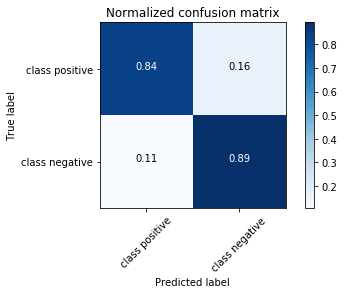

In [26]:
  
import itertools

from sklearn.metrics import confusion_matrix
class_names= target_names
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Logistic Regression

In [27]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html

from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
 #refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer


  

C:\Users\taxak\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Train , test and CV 

In [28]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts, Score, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

C=1

nb =  LogisticRegression(C= 1, penalty='l2');

    # fitting the model on crossvalidation train
nb.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
pred = nb.predict(X_cv)

    # evaluate CV accuracy
acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
print('\nCV accuracy for C = %d is %d%%' % (C, acc))
    
nb =  LogisticRegression(C=1, penalty='l2');
nb.fit(X_tr,y_tr)
pred = nb.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for C=1 is %d%%' % (acc))


CV accuracy for C = 1 is 86%

****Test accuracy for C=1 is 87%


## Gridsearch using accuracy as a measure

In [29]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]



#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_1, y_1)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8822304117929819


## GridsearchCV using F1 score as a measure

In [30]:


from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label="positive")
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring=f1_scorer)
model.fit(X_1,y_1)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.883351848912871


## L1 Regularization 
### Error report as lambda increase and C decreases

In [31]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

# Set regularization parameter
for i, C in enumerate((100, 1, 0.01,.001,.0001,.00001)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1')
    clf_l2_LR = LogisticRegression(C=C, penalty='l2')
    clf_l1_LR.fit(X_1, y_1)
    clf_l2_LR.fit(X_1, y_1)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%f" % C)
    w = clf_l1_LR.coef_
    print("elements of W* being non-zero L1 regularization")
    print(np.count_nonzero(w))
    print("Sparsity with L1 penalty: %f%%" % sparsity_l1_LR)
    pred =  clf_l1_LR.predict(X_test)
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy  for L1 regulizer %d%%' % (acc))
    
    
    
    w = clf_l2_LR.coef_
    print("elements of W* being non-zero L1 regularization")
    print(np.count_nonzero(w))
    print("Sparsity with L2 penalty: %f%%" % sparsity_l2_LR)
    pred =  clf_l2_LR.predict(X_test)
    
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy for L2 regulaizer is %d%%' % (acc))

  

C=100.000000
elements of W* being non-zero L1 regularization
3961
Sparsity with L1 penalty: 87.484201%

****Test accuracy  for L1 regulizer 85%
elements of W* being non-zero L1 regularization
27071
Sparsity with L2 penalty: 14.462209%

****Test accuracy for L2 regulaizer is 86%
C=1.000000
elements of W* being non-zero L1 regularization
2328
Sparsity with L1 penalty: 92.644085%

****Test accuracy  for L1 regulizer 87%
elements of W* being non-zero L1 regularization
27071
Sparsity with L2 penalty: 14.462209%

****Test accuracy for L2 regulaizer is 88%
C=0.010000
elements of W* being non-zero L1 regularization
67
Sparsity with L1 penalty: 99.788296%

****Test accuracy  for L1 regulizer 76%
elements of W* being non-zero L1 regularization
27071
Sparsity with L2 penalty: 14.462209%

****Test accuracy for L2 regulaizer is 86%
C=0.001000
elements of W* being non-zero L1 regularization
6
Sparsity with L1 penalty: 99.981041%

****Test accuracy  for L1 regulizer 62%
elements of W* being non-zero 

# RBF-(Curve)

# Decision Tree 


## CV error vs depth


The optimal depth is 9.


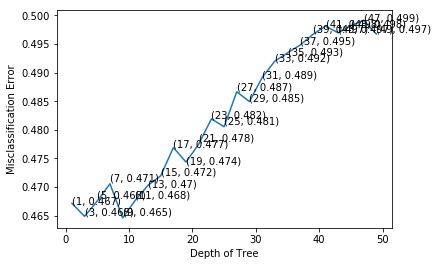

('the misclassification error for each depth is : ', array([0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.48, 0.47, 0.48,
       0.48, 0.48, 0.49, 0.48, 0.49, 0.49, 0.49, 0.49, 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 ]))


In [32]:
from sklearn import tree

# split the data set into train and test
X_2, X_tes, y_2, y_tes = cross_validation.train_test_split(reduced_vectors,Score,test_size=0.3)
# split the train data set into cross validation train and cross validation testtest_split(reduced_vectors, Score, test_size=0.3, random_state=0)

X_t, X_c, y_t, y_c = cross_validation.train_test_split(X_2, y_2, test_size=0.3)

# creating odd list of K for KNN
myList = list(range(0,50))
depth = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in depth:
    clf = tree.DecisionTreeClassifier(max_depth=k)
    sco = cross_val_score(clf, X_2, y_2, cv=5, scoring='accuracy')
    cv_scores.append(sco.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_d = depth[MSE.index(min(MSE))]
print('\nThe optimal depth is %d.' % optimal_d)

# plot misclassification error vs k 
plt.plot(depth, MSE)
for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Depth of Tree')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth is : ", np.round(MSE,3))

In [33]:
#instantiate learning model depth = optimal_d
d_optimal = tree.DecisionTreeClassifier(max_depth=optimal_d)

# fitting the model
d_optimal.fit(X_2, y_2)

# predict the response
pred = d_optimal.predict(X_tes)

# evaluate accuracy
acc = accuracy_score(y_tes, pred) * 100
print('\nThe accuracy of the Decision Tree (truncated SVD) = %d is %f%%' % (optimal_d, acc))


The accuracy of the Decision Tree (truncated SVD) = 9 is 53.693318%


# Grid search for best depth

In [34]:
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters,cv=5)
clf.fit(X=X_2, y=y_2)
print(clf.best_estimator_)
print (clf.best_score_, clf.best_params_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
(0.5352654350662729, {'max_depth': 9})


# Random Forest on BOW

# Train , test and CV


The optimal depth is 5.


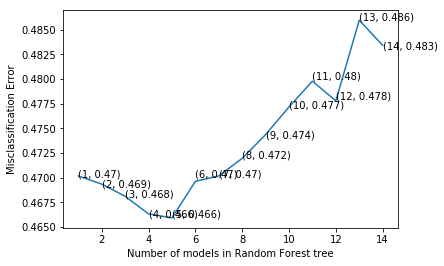

('the misclassification error for number of models is : ', array([0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.48, 0.48,
       0.48, 0.49, 0.48]))


In [35]:
from sklearn.ensemble import RandomForestClassifier

# creating odd list of K for KNN
depth = list(range(1,15))
 

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in depth:
    clf = RandomForestClassifier(max_depth=k, random_state=0)
    sco = cross_val_score(clf, X_2, y_2, cv=5, scoring='accuracy')
    cv_scores.append(sco.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_d = depth[MSE.index(min(MSE))]
print('\nThe optimal depth is %d.' % optimal_d)

# plot misclassification error vs k 
plt.plot(depth, MSE)
for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of models in Random Forest tree')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for number of models is : ", np.round(MSE,3))

In [36]:
d_optimal = RandomForestClassifier(max_depth=optimal_d)

# fitting the model
d_optimal.fit(X_2, y_2)

# predict the response
pred = d_optimal.predict(X_tes)

# evaluate accuracy
acc = accuracy_score(y_tes, pred) * 100
print('\nThe accuracy of the Random forest Tree (truncated SVD) = %d is %f%%' % (optimal_d, acc))


The accuracy of the Random forest Tree (truncated SVD) = 5 is 53.933664%


# Gridsearch for number of models (M) in which data to train and test

In [52]:
parameters = {'max_depth':range(1,30)}
clf = GridSearchCV(RandomForestClassifier(), parameters,cv=5)
clf.fit(X=X_2, y=y_2)
print(clf.best_estimator_)
print (clf.best_score_, clf.best_params_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
(0.6696655449488359, {'max_depth': 8})


# Clustering


## KMeans

## Elbow method to find optimal number of clusters

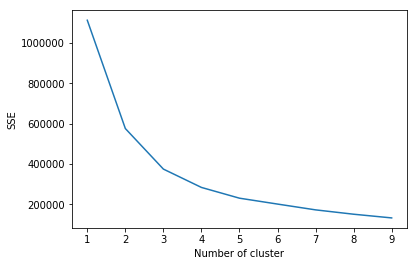

In [49]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(reduced_vectors)
    
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

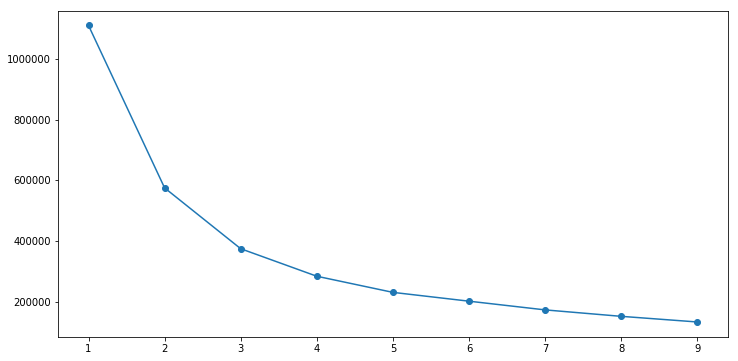

In [50]:
cluster_range = range( 1, 10 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit(reduced_vectors)
    cluster_errors.append( clusters.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:10]

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [51]:
clusters_df[0:9]

,cluster_errors,num_clusters
0,1.111763e+06,1
1,5.752819e+05,2
2,3.744271e+05,3
3,2.835557e+05,4
4,2.302885e+05,5
5,2.011638e+05,6
6,1.724173e+05,7
7,1.511175e+05,8
8,1.324917e+05,9


In [52]:
from sklearn.preprocessing import scale

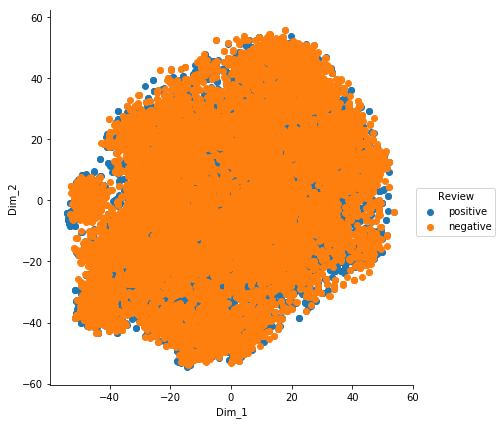

In [53]:

dim_reduction_model =TruncatedSVD(n_components=50,random_state=0)
reduced_vectors = dim_reduction_model.fit_transform(final_counts)


model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(reduced_vectors) 

# attaching the label for each 2-d data point 
tsne_dat = np.vstack((tsne_data.T, Score)).T
# creating a new data fram which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_dat, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()


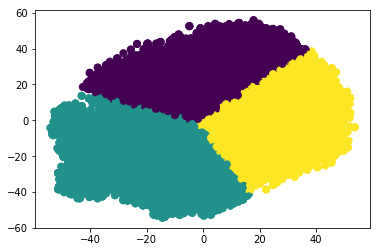

In [54]:
labels = KMeans(3, random_state=0).fit_predict(tsne_data)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels,
            s=50, cmap='viridis');

In [92]:
print(labels)

[1 1 2 ... 0 1 0]


# K-medoids

In [56]:
def assign_nearest(ids_of_mediods):
    dists = dist(tsne_data[:,None,:], tsne_data[None,ids_of_mediods,:])
    return np.argmin(dists, axis=1)


def dist(xa, xb):
    if EUCLIDEAN:
        return np.sqrt(np.sum(np.square(xa-xb), axis=-1))
    else:
        return np.sum(np.abs(xa - xb), axis=-1)


def find_medoids(assignments):
    medoid_ids = np.full(k, -1, dtype=int)
    subset = np.random.choice(n, batch_sz, replace=False)

    for i in range(k):
        indices = np.intersect1d(np.where(assignments==i)[0], subset)
        distances = dist(tsne_data[indices, None, :], tsne_data[None, indices, :]).sum(axis=0)
        medoid_ids[i] = indices[np.argmin(distances)]

    return medoid_ids


def kmeds(iterations=20):
    print("Initializing to random medoids.")
    ids_of_medoids = np.random.choice(n, k, replace=False)
    class_assignments = assign_nearest(ids_of_medoids)

    for i in range(iterations):
        print("\tFinding new medoids.")
        ids_of_medoids = find_medoids(class_assignments)
        print("\tReassigning points.")
        new_class_assignments = assign_nearest(ids_of_medoids)

        diffs = np.mean(new_class_assignments != class_assignments)
        class_assignments = new_class_assignments

        print("iteration {:2d}: {:.2%} of points got reassigned."
              "".format(i, diffs))
        if diffs <= 0.01:
            break

    return class_assignments, ids_of_medoids


######################### Generate Fake Data
print("Initializing Data.")
d = 3
k = 6
n = k * 1000000
batch_sz = 1000
tsne_data = np.random.normal(size=(n, d))
EUCLIDEAN = False

print("n={}\td={}\tk={}\tbatch_size={} ".format(n, d, k, batch_sz))
print("Distance metric: ", "Eucledian" if EUCLIDEAN else "Manhattan")

print("\nMaking k-groups as:")
for kk in range(k):
    dd = (kk-1)%d
    print("    x[{}:{}, {}] += {}".format(kk*n//k, (kk+1)*n//k, dd , 3*d*kk))
    tsne_data[kk*n//k:(kk+1)*n//k,dd] += 3*d*kk

######################### Fitting
print("\nFitting Kmedoids.")
final_assignments, final_medoid_ids = kmeds()

print("\nFitting Kmeans from Scikit-Learn")
fit = KMeans(n_clusters=k).fit(tsne_data)
kmeans_assignments = fit.labels_
kmeans = fit.cluster_centers_

mismatch = np.zeros((k, k))
for i, m in (zip(final_assignments, kmeans_assignments)):
    mismatch[i, m] += 1

np.set_printoptions(suppress=True)
print("\nKMedoids:")
print(tsne_data[final_medoid_ids, ])
print("K-Medoids class sizes:")
print(mismatch.sum(axis=-1))
print("\nKMeans:")
print(kmeans)
print("K-Means class sizes:")
print(mismatch.sum(axis=0))
print("\nMismatch between assignment to Kmeans and Kmedoids:")
print(mismatch)


print("Should ideally be {} * a permutation matrix.".format(n//k))

Initializing Data.
n=6000000	d=3	k=6	batch_size=1000 
('Distance metric: ', 'Manhattan')

Making k-groups as:
    x[0:1000000, 2] += 0
    x[1000000:2000000, 0] += 9
    x[2000000:3000000, 1] += 18
    x[3000000:4000000, 2] += 27
    x[4000000:5000000, 0] += 36
    x[5000000:6000000, 1] += 45

Fitting Kmedoids.
Initializing to random medoids.
	Finding new medoids.
	Reassigning points.
iteration  0: 1.73% of points got reassigned.
	Finding new medoids.
	Reassigning points.
iteration  1: 19.24% of points got reassigned.
	Finding new medoids.
	Reassigning points.
iteration  2: 2.23% of points got reassigned.
	Finding new medoids.
	Reassigning points.
iteration  3: 17.92% of points got reassigned.
	Finding new medoids.
	Reassigning points.
iteration  4: 1.71% of points got reassigned.
	Finding new medoids.
	Reassigning points.
iteration  5: 0.53% of points got reassigned.

Fitting Kmeans from Scikit-Learn

KMedoids:
[[-0.51 -0.44 26.39]
 [ 7.67  0.16 -0.32]
 [36.01 -0.26  0.22]
 [ 0.47  0.

# Hierarchical clustering

# AgglomerativeClustering

In [73]:
data_f = tsne_data[0:3000,:]
sc = Score.head(30000)

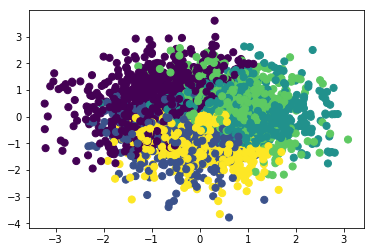

In [93]:
from sklearn.cluster import AgglomerativeClustering

labels = AgglomerativeClustering(n_clusters=5).fit_predict(data_f)
plt.scatter(data_f[:, 0], data_f[:, 1], c=labels,s=50, cmap='viridis');

Using Ward Linkage


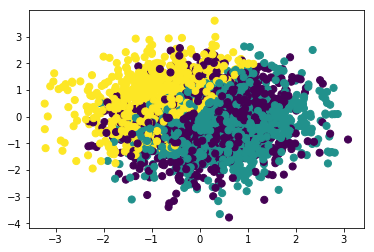

In [87]:
print("Using Ward Linkage")
label = AgglomerativeClustering(linkage='ward', n_clusters=3).fit_predict(data_f)
plt.scatter(data_f[:, 0], data_f[:, 1], c=label,s=50, cmap='viridis');
                


                
                   

Using average linkage


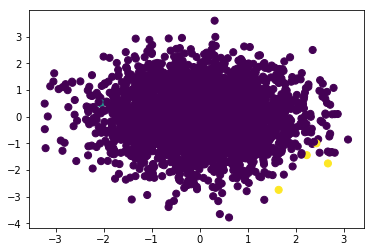

In [88]:
print("Using average linkage")
abel = AgglomerativeClustering(linkage='average', n_clusters=3).fit_predict(data_f)
plt.scatter(data_f[:, 0], data_f[:, 1], c=abel,s=50, cmap='viridis');

Using complete linkage


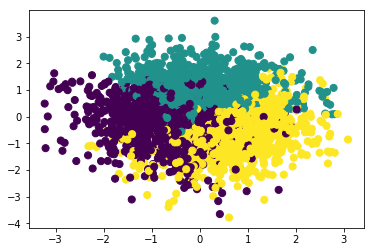

In [89]:
print("Using complete linkage")
abel = AgglomerativeClustering(linkage='complete', n_clusters=3).fit_predict(data_f)
plt.scatter(data_f[:, 0], data_f[:, 1], c=abel,s=50, cmap='viridis');

In [76]:
from time import time


from scipy import ndimage


from sklearn import manifold

X = data_f
y = sc
n_samples, n_features = X.shape

np.random.seed(0)



#----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, X, labels, 
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)


plt.show()

Computing embedding
Done.
ward : 0.38s


KeyError: 0L

In [ ]:
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.pipeline import make_pipeline

#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import make_pipeline as make_pipeline_imb
#from imblearn.metrics import classification_report_imbalanced




In [64]:
#from imblearn.over_sampling import SMOTE, ADASYN
#X_resample, y_resample = SMOTE().fit_sample(final_counts, Score)


#X_resampled, y_resampled = ADASYN().fit_sample(final_counts,Score)

In [61]:
# split the data set into train and test
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X_resample, y_resample, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
#X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)
# creating odd list of K for KNN
#myList = list(range(0,50))
#neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
#cv_scores = []

# perform 10-fold cross validation
#for k in neighbors:
#    knn = BernoulliNB(alpha=k, binarize=0.0, class_prior=None, fit_prior=True)
#    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
#    cv_scores.append(scores.mean())

# changing to misclassification error
'''MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))'''

'MSE = [1 - x for x in cv_scores]\n\n# determining best k\noptimal_k = neighbors[MSE.index(min(MSE))]\nprint(\'\nThe optimal number of neighbors is %d.\' % optimal_k)\n\n# plot misclassification error vs k \nplt.plot(neighbors, MSE)\n\nfor xy in zip(neighbors, np.round(MSE,3)):\n    plt.annotate(\'(%s, %s)\' % xy, xy=xy, textcoords=\'data\')\n\nplt.xlabel(\'Number of Neighbors K\')\nplt.ylabel(\'Misclassification Error\')\nplt.show()\n\nprint("the misclassification error for each k value is : ", np.round(MSE,3))'

In [62]:
# instantiate learning model k = optimal_k
#knn_optimal = BernoulliNB(alpha=optimal_k, binarize=0.0, class_prior=None, fit_prior=True)

# fitting the model
#knn_optimal.fit(X_1, y_1)

# predict the response
#pred = knn_optimal.predict(X_test)

# evaluate accuracy
#acc = accuracy_score(y_test, pred) * 100
#print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

# Bi-Grams and n-Grams.

#### Now that we have our list of words describing positive and negative reviews lets analyse them.

#### We begin analysis by getting the frequency distribution of the words as shown below

In [115]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

NameError: name 'all_positive_words' is not defined

## Observation:- 
#### From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. 
#### So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [116]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(sorted_d['Text'].values)

#CountVectorizer() in sklearn is used  Convert a collection of text documents to a matrix of token counts
#This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.


In [117]:
final_bigram_counts.get_shape()

(20802, 475855)

# TF-IDF

In [118]:
# TfidfVectorizer() is used to Convert a collection of raw documents to a matrix of TF-IDF features.

#Equivalent to CountVectorizer followed by TfidfTransformer.

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sorted_d['Text'].values)


In [119]:
final_tf_idf.get_shape()

(20802, 475855)

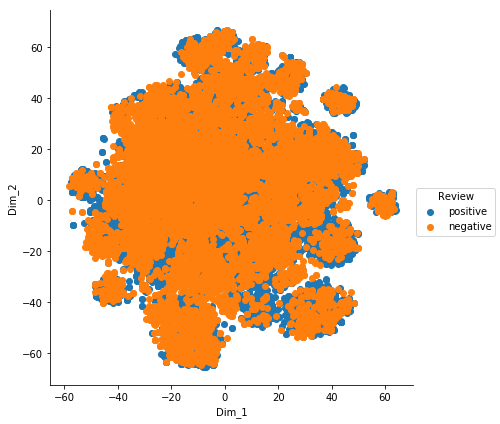

In [120]:

dim_reduction_model =TruncatedSVD(n_components=50,random_state=0)
reduced_vectors = dim_reduction_model.fit_transform(final_tf_idf)


model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(reduced_vectors) 


# attaching the label for each 2-d data point 
tsne_dat = np.vstack((tsne_data.T, Score)).T
# creating a new data fram which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_dat, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

In [121]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_tf_idf, Score, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(23)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 23 is %d%%' % (acc))


CV accuracy for k = 1 is 73%

CV accuracy for k = 3 is 77%

CV accuracy for k = 5 is 78%

CV accuracy for k = 7 is 78%

CV accuracy for k = 9 is 79%

CV accuracy for k = 11 is 80%

CV accuracy for k = 13 is 81%

CV accuracy for k = 15 is 81%

CV accuracy for k = 17 is 81%

CV accuracy for k = 19 is 81%

CV accuracy for k = 21 is 81%

CV accuracy for k = 23 is 81%

CV accuracy for k = 25 is 82%

CV accuracy for k = 27 is 82%

CV accuracy for k = 29 is 82%

****Test accuracy for k = 23 is 81%



The optimal number of neighbors is 45.


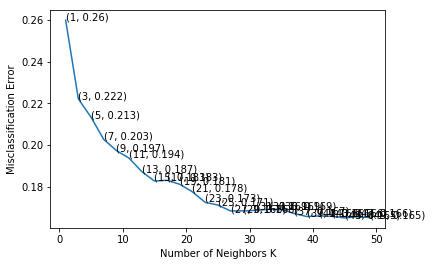

('the misclassification error for each k value is : ', array([0.26, 0.22, 0.21, 0.2 , 0.2 , 0.19, 0.19, 0.18, 0.18, 0.18, 0.18,
       0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17,
       0.17, 0.17, 0.17]))


In [122]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [123]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 45 is 83.640442%



The optimal number of neighbors is 45.


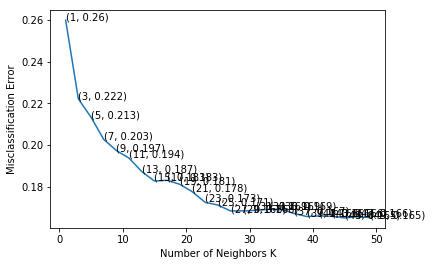

('the misclassification error for each k value is : ', array([0.26, 0.22, 0.21, 0.2 , 0.2 , 0.19, 0.19, 0.18, 0.18, 0.18, 0.18,
       0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17,
       0.17, 0.17, 0.17]))


In [124]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [125]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 45 is 83.640442%


# Naive Bayes

In [126]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_tf_idf, Score, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    nb = BernoulliNB(alpha=i, binarize=0.0, class_prior=None, fit_prior=True)

    # fitting the model on crossvalidation train
    nb.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = nb.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for alpha = %d is %d%%' % (i, acc))
    
nb = KNeighborsClassifier(1)
nb.fit(X_tr,y_tr)
pred = nb.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = 1 is %d%%' % (acc))


CV accuracy for alpha = 1 is 89%

CV accuracy for alpha = 3 is 88%

CV accuracy for alpha = 5 is 87%

CV accuracy for alpha = 7 is 86%

CV accuracy for alpha = 9 is 85%

CV accuracy for alpha = 11 is 84%

CV accuracy for alpha = 13 is 84%

CV accuracy for alpha = 15 is 83%

CV accuracy for alpha = 17 is 82%

CV accuracy for alpha = 19 is 81%

CV accuracy for alpha = 21 is 80%

CV accuracy for alpha = 23 is 79%

CV accuracy for alpha = 25 is 78%

CV accuracy for alpha = 27 is 77%

CV accuracy for alpha = 29 is 75%

****Test accuracy for alpha = 1 is 74%



The optimal alpha is 1.


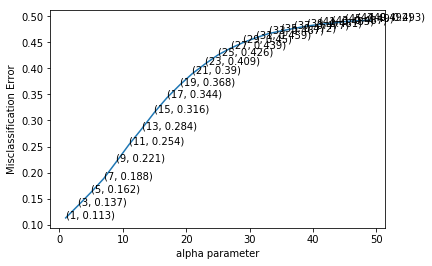

('the misclassification error for each alpha value is : ', array([0.11, 0.14, 0.16, 0.19, 0.22, 0.25, 0.28, 0.32, 0.34, 0.37, 0.39,
       0.41, 0.43, 0.44, 0.45, 0.46, 0.47, 0.47, 0.48, 0.48, 0.48, 0.49,
       0.49, 0.49, 0.49]))


In [127]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    nb = BernoulliNB(alpha=k, binarize=0.0, class_prior=None, fit_prior=True)
    scores = cross_val_score(nb, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal alpha is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('alpha parameter')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [128]:
# instantiate learning model k = optimal_k
nb_optimal = BernoulliNB(alpha=optimal_alpha, binarize=0.0, class_prior=None, fit_prior=True)

# fitting the model
nb_optimal.fit(X_1, y_1)

# predict the response
pred = nb_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes for alpha = %d is %f%%' % (optimal_alpha, acc))




The accuracy of the naive bayes for alpha = 1 is 89.168402%


#  Precision , recall ,f1-score

In [129]:
from sklearn.metrics import classification_report

target_names = ['class positive', 'class negative']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

class positive       0.92      0.85      0.89      3121
class negative       0.86      0.93      0.90      3120

   avg / total       0.89      0.89      0.89      6241



# Confusion Matrix

Confusion matrix, without normalization
[[2666  455]
 [ 221 2899]]
Normalized confusion matrix
[[0.85 0.15]
 [0.07 0.93]]


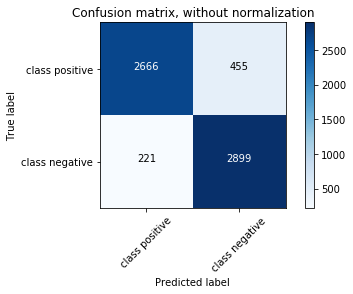

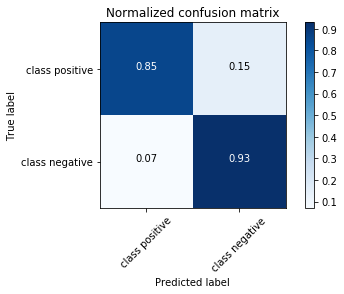

In [130]:

import itertools

from sklearn.metrics import confusion_matrix
class_names= target_names
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Feature Selection 

In [131]:
features = tf_idf_vect.get_feature_names()
len(features)


475855

In [132]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=50):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,50)

In [133]:
top_tfidf

,feature,tfidf
0,amp,0.277300
1,books,0.164347
2,books amp,0.117655
3,for preschoolers,0.117655
4,amp turned,0.117655
5,it aired,0.117655
6,amp songs,0.117655
7,the lp,0.117655
8,aired on,0.117655
9,television years,0.117655


# Logistic Regression (tf-idf)

### GridSearch to find optimum C

In [136]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]



#Using GridSearchCV scoring with accuracy
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_1, y_1)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9123537894568178


### gridsearch with f1 score as a meaure

In [137]:

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label="positive")
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring=f1_scorer)
model.fit(X_1,y_1)

print(model.best_estimator_)
print(model.score(X_test, y_test))

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9128286852589641


## L1 and L2 Reguliazer (Sparsity and error report)

In [138]:
 coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%f" % C)
    w = clf_l1_LR.coef_
    print("elements of W* being non-zero L1 regularization")
    print(np.count_nonzero(w))
    print("Sparsity with L1 penalty: %f%%" % sparsity_l1_LR)
    pred =  clf_l1_LR.predict(X_test)
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy  for L1 regulizer %d%%' % (acc))
    
    
    
    w = clf_l2_LR.coef_
    print("elements of W* being non-zero L1 regularization")
    print(np.count_nonzero(w))
    print("Sparsity with L2 penalty: %f%%" % sparsity_l2_LR)
    pred =  clf_l2_LR.predict(X_test)
    
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy for L2 regulaizer is %d%%' % (acc))

IndentationError: unexpected indent (<ipython-input-138-0cca98cc6221>, line 2)

# Word2Vec

#### Word2vec is a group of related models that are used to produce word embeddings. 
#### Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with       each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

In [32]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [33]:
#Here we are doing datacleaning and pre-processing
#Converting all the alphabets to lower case
import gensim
i=0
list_of_sent=[]
for sent in sorted_d['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [34]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)  
#min_count (int) – Ignores all words with total frequency lower than this.
#workers (int) – Use these many worker threads to train the model (=faster training with multicore machines).
#size (int) – Dimensionality of the feature vectors

In [40]:


model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(w2v_model) 


# attaching the label for each 2-d data point 
tsne_dat = np.vstack((tsne_data.T, Score)).T
# creating a new data fram which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_dat, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

ValueError: setting an array element with a sequence.

# Avg Word2Vec and tf-idf weighted word2vec

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sent_vectors) 


# attaching the label for each 2-d data point 
tsne_data = np.vstack((tsne_data.T, Score)).T
# creating a new data fram which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    


In [ ]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tfidf_sent_vectors) 


# attaching the label for each 2-d data point 
tsne_data = np.vstack((tsne_data.T, Score)).T
# creating a new data fram which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()